<h1> Uncertainty Quantification in Transporting Crude Oil </h1>

One of the main problems in uncertainty quantification is the parsimonious computation of statical moments; treating the model as a black box. In Effective Quadratures there are routines for achieveing prceisely that! In this notebook, we will consider the case where a user would like to estimate key statistical quantities using a numerical integration technique known as sparse grids.

First, we must define our *black box*. Consider the flow of crude oil through a pipe. Our objective is to estimate the power required for transporting the crude oil along a pipe that has a length of $L=1000$ meters and a diameter of $D=1$ meter. The density of crude oil is 870 $kg/m^3$. The two uncertainties are the kinematic viscosity and the flow velocity, given by
- $\mu$: Characterized by a Beta (1.3, 2.5) distribution between [0.0040, 0.0060]
- $v$: Characterized by a Gaussian distribution with a mean of 5.0 m/s and a variance of 0.1.


In [1]:
import numpy as np
from equadratures import *

Now we must define our black box model. The power is expressed as
$$Power=\Delta P\times Q$$
where
$$\Delta P=2f\left(\frac{L}{D}\right)\left(\rho v^{2}\right), \; \; \; \; Q=\frac{\pi}{4}D^{2}v$$
and assuming the flow is laminar, we have
$$f=\frac{16}{Re} \; \; where \; \; Re=\frac{Dv\rho}{\mu}.$$

Variable $f$ denotes the friction, $\Delta P$ denotes the pressure loss across the pipe, and $Re$ denotes the Reynolds number. These equations are coded in the **blackbox** below.

In [29]:
def blackbox(x):
    mu = x[0]
    velocity = x[1]
    D = 1.0
    L = 1000.0
    density = 870.0
    Q = np.pi * D**2 * velocity * 1.0/4.0
    Reynolds_number = D * velocity * density * 1.0/mu
    f = 16.0 / Reynolds_number
    delta_pressure = 2.0 * f * (L/D) * density * velocity**2
    return delta_pressure * Q

Now let us feed in these uncertainties using the **Parameter** class

In [30]:
viscosity = Parameter(distribution='Beta', lower=0.0040, upper=0.0060, shape_parameter_A=1.3, shape_parameter_B=2.5, order=2)
velocity = Parameter(distribution='Gaussian', shape_parameter_A=5.0, shape_parameter_B=0.1, order=2)
mybasis = Basis('Tensor grid')

We will use a tensor grid for this experiment. If you feel adventurous, replace this with a sparse grid! For now though, let us plot these distributions.  

In [31]:
samples = viscosity.getSamples(5000)
x, y  = viscosity.getPDF(5000)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.hist(samples, 30, normed=1, facecolor='orangered', edgecolor='black', linewidth=0.5)
plt.plot(x, y, c='navy')
std_dev = np.std(samples)
adjust_spines(ax, ['left', 'bottom'])
plt.xlabel('Viscosity', fontsize=13)
plt.ylabel('PDF', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

In [32]:
samples = velocity.getSamples(5000)
x, y  = velocity.getPDF(5000)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.hist(samples, 30, normed=1, facecolor='slateblue', edgecolor='black', linewidth=0.5)
plt.plot(x, y, c='navy')
std_dev = np.std(samples)
ax.set_axisbelow(True)
adjust_spines(ax, ['left', 'bottom'])
plt.xlabel('Velocity', fontsize=13)
plt.ylabel('PDF', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

Now we shall compute the coefficients associated with a polynomial. Note: we are using the **Polyint** class, as this is the class for direction integration methods.

In [59]:
poly = Polyint([viscosity, velocity], mybasis)
no_of_points = len(poly.quadratureWeights)
function_evals = np.reshape( evalfunction(points=poly.quadraturePoints, function=blackbox) , (no_of_points, 1))
poly.computeCoefficients(function_evals)

The grid below corresponds to the locations in parameter space where model evaluations were sought.

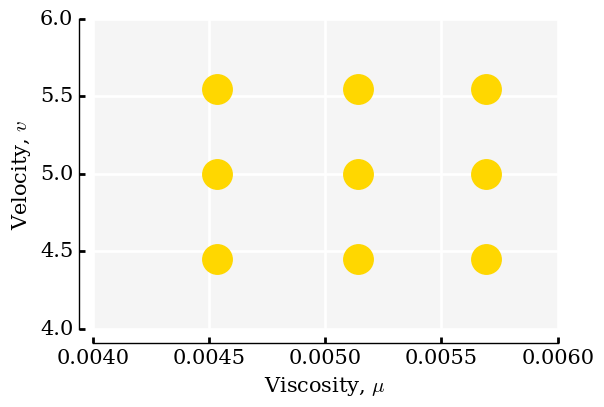

In [85]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.scatter(poly.quadraturePoints[:,0], poly.quadraturePoints[:,1] , marker='o', s=450, color='gold')
adjust_spines(ax, ['left', 'bottom'])
plt.xlabel('Viscosity, $\mu$', fontsize=15)
plt.ylabel('Velocity, $v$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([viscosity.lower, viscosity.upper])
plt.xlim([0.0040, 0.0060])
plt.ylim([4.0, 6.0])
plt.show()

Now lets have a look at the polynomial coefficients, we are looking for an exponential decay in the coefficients---indicating that the polynomial has done a good job interpolating the data.

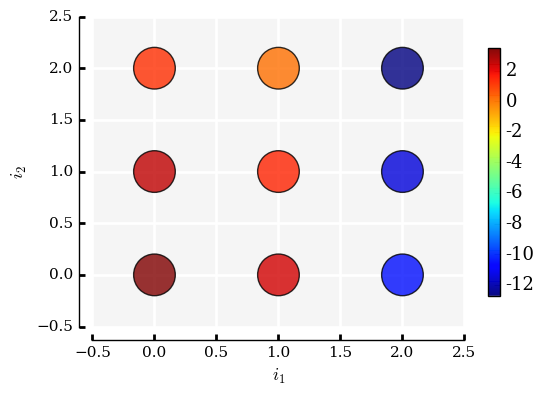

In [81]:
x, y, z, max_order = twoDgrid(poly.coefficients, poly.multi_index)
G = np.log10(np.abs(z))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
cax = plt.scatter(x, y, s=900, marker='o', c=G, cmap='jet', alpha=0.8)
plt.xlim(-0.5, max_order)
plt.ylim(-0.5, max_order)
adjust_spines(ax, ['left', 'bottom'])
ax.set_axisbelow(True)
plt.xlabel('$i_1$', fontsize=13)
plt.ylabel('$i_2$', fontsize=13)
cbar = plt.colorbar(extend='neither', spacing='proportional',
                orientation='vertical', shrink=0.8, format="%.0f")
cbar.ax.tick_params(labelsize=13)
plt.xlim([-0.5, 2.5])
plt.ylim([-0.5, 2.5])
plt.show()
del x, y , z

Now let us compute the Power (as approximated by the polynomial)

In [71]:
N = 5000
fun = poly.getPolyFitFunction()
x, fx = poly.getFunctionSamples(N)

Let us go a step further, and compute its PDF!

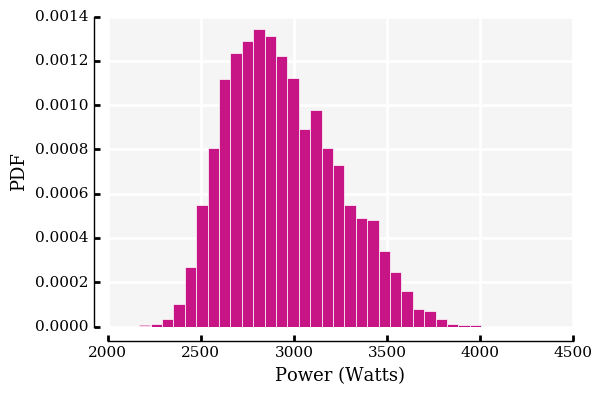

In [78]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.hist(fx, 30, normed=1, facecolor='mediumvioletred', edgecolor='white', linewidth=0.5)
std_dev = np.std(samples)
ax.set_axisbelow(True)
adjust_spines(ax, ['left', 'bottom'])
plt.xlabel('Power (Watts)', fontsize=13)
plt.ylabel('PDF', fontsize=13)
plt.show()

And for completeness, we can also render its statistics, by calling the function getStatistics()

In [79]:
g = poly.getStatistics()

In [80]:
print g.mean, g.variance

3284.67594934 228502.979328


That concludes our notebook!